# Chapitre 9 : Usages avancés

### Coder du matériau qualitatif

In [2]:
from docx import Document

doc = Document("./data/entretien.docx")
paragraphes = [i.text for i in doc.paragraphs]
print(paragraphes[0])

Début entretien médecin


In [3]:
def extraire_texte(fichier):
    doc = Document(fichier)
    paragraphes = [i.text for i in doc.paragraphs]
    return "\n".join(paragraphes)

In [4]:
import regex as re

def extraire_balise(texte,balise):
    debut = '<'+balise+'>'
    fin = '</'+balise+'>'
    texte = texte.replace("\n"," ")
    passages = re.findall(debut+".*?"+fin,texte)
    return passages

In [5]:
import os

liste_docs = [i for i in os.listdir("data") if "docx" in i]
corpus = {i:extraire_texte("data/"+i) for i in liste_docs}
corpus_f = [i for i in corpus if ("<difference>" in corpus[i]) 
                              and ("<comparaison>" in corpus[i])]
print(corpus_f)

['entretien.docx']


In [6]:
import pandas as pd

corpus = [[i,extraire_texte("data/"+i)] for i in liste_docs]
corpus = pd.DataFrame(corpus)
corpus.columns = ["fichier","texte"]
corpus = corpus.set_index("fichier")
corpus["<difference>"] = corpus["texte"].str.contains("<difference>")
corpus["<comparaison>"] = corpus["texte"].str.contains("<comparaison>")
corpus.head()

,texte,<difference>,<comparaison>
fichier,,,
entretien.docx,Début e...,True,True


### Format HTML

In [7]:
import bs4

file = "data/fichier_europresse.HTML"
with open(file, "r", encoding="utf8") as f:
    html = bs4.BeautifulSoup(f,"lxml")
type(html)

bs4.BeautifulSoup

In [8]:
corpus = html.findAll("article")
print(len(corpus))

50


In [9]:
def extraire_contenu(article):
    try:
        titre = article.find("div",
                {"class":"titreArticle"}).text 
    except:
        titre = None
    
    try:
        publication = article.find("span",
                {"class":"DocPublicationName"}).text
    except:
        publication = None
     
    try:
        text = article.find("div",
                {"class":"DocText clearfix"}).text
    except:
        text = None

    return [titre,publication,text]

In [10]:

file = "data/fichier_europresse.HTML"
with open(file, "r", encoding="utf8") as f:
    html = bs4.BeautifulSoup(f,"lxml")

corpus = html.find_all("article")
donnees = [extraire_contenu(article) for article in corpus]
donnees = pd.DataFrame(donnees,
    columns = ["titre","journal","texte"])
donnees.head()

,titre,journal,texte
0,L'UE s...,La Tri...,- 18...
1,L'UE v...,La Tri...,- 18...
2,Le co...,La Tri...,Alors...
3,Corona...,La Tri...,- 18...
4,Plus d...,La Tri...,- 17...


### Utilisation des API

In [11]:
import pandas as pd
from pytrends.request import TrendReq

pytrends = TrendReq(geo="FR", tz=360)
pytrends.build_payload(kw_list=["cancer"])
requetes = pytrends.related_queries()

requetes["cancer"]["top"][0:10]

,query,value
0,cancer ...,100
1,cancer ...,80
2,horosco...,65
3,cancer ...,62
4,symptome,56
5,symptom...,55
6,cancer ...,45
7,prostate,45
8,symptom...,44
9,cancer ...,44


In [12]:
import geocoder
g = geocoder.osm('Cours Julien, Marseille')
infos = g.json
print(infos["address"])

Cours Julien, Thiers, 1er Arrondissement, Marseille, Bouches-du-Rhône, Provence-Alpes-Côte d'Azur, France métropolitaine, 13001, France


In [14]:

import tweepy as tw
import json

# Indique les codes Twitter (à remplacer par les vôtres)
api_key = codes['api_key'] 
api_secret_key = codes['api_secret_key'] 
access_token = codes['access_token'] 
access_token_secret = codes['access_token_secret'] 

# Initialise la connexion à l'API
auth = tw.OAuthHandler(api_key, api_secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

# Réalise la recherche
mot = "#cancer"
date = "2020-06-01"
tweets = tw.Cursor(api.search, q=mot, 
            lang="fr", since=date).items(10)

# Affiche le résultat
tweets = [t._json for t in tweets]
print(json.dumps(tweets[0], indent=2, sort_keys=True)[1000:2000])

"retweeted_status": {
    "contributors": null,
    "coordinates": null,
    "created_at": "Tue Dec 22 18:00:00 +0000 2020",
    "entities": {
      "hashtags": [
        {
          "indices": [
            8,
            15
          ],
          "text": "Cancer"
        }
      ],
      "symbols": [],
      "urls": [],
      "user_mentions": []
    },
    "favorite_count": 377,
    "favorited": false,
    "geo": null,
    "id": 1341443384628678658,
    "id_str": "1341443384628678658",
    "in_reply_to_screen_name": null,
    "in_reply_to_status_id": null,
    "in_reply_to_status_id_str": null,
    "in_reply_to_user_id": null,
    "in_reply_to_user_id_str": null,
    "is_quote_status": false,
    "lang": "fr",
    "metadata": {
      "iso_language_code": "fr",
      "result_type": "recent"
    },
    "place": null,
    "retweet_count": 76,
    "retweeted": false,
    "source": "<a href=\"https://about.twitter.com/products/tweetdeck\" rel=\"nofollow\">TweetDeck</a>",
    "text": "Chez

In [15]:
import wikipedia as wp 
wp.set_lang("fr")
pages = wp.search("cancer",results=100)
pages[0:8]

['Cancer',
 'Cancer (astrologie)',
 'Cancer colorectal',
 'Cancer du poumon',
 'Cancer du sein',
 'Cancer du pancréas',
 'Cancer de la prostate',
 "Cancer de l'œsophage"]

In [16]:
corpus = []
for i in pages[0:8]:
    try:
        p = wp.page(i)
    except wp.DisambiguationError:
        print("La page", repr(i), "est ambigue et sera ignoré.")
        continue
    corpus.append([i,p.content])

corpus = pd.DataFrame(corpus,columns = ["page","contenu"])
corpus.to_csv("data/corpus_cancer_wiki.csv")

### Traitement textuel

In [17]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

True

In [18]:
import nltk
texte = corpus.loc[0,"contenu"]
texte_tokenise = nltk.word_tokenize(texte)
print(texte_tokenise[0:10])

['Le', 'cancer', 'est', 'une', 'maladie', 'provoquée', 'par', 'la', 'transformation', 'de']


In [19]:
from nltk.stem.snowball import FrenchStemmer

stemmer = FrenchStemmer()
texte_lemmatise = [stemmer.stem(m) for m in texte_tokenise]
print(texte_lemmatise[0:10])

['le', 'canc', 'est', 'une', 'malad', 'provoqu', 'par', 'la', 'transform', 'de']


In [20]:
from nltk.corpus import stopwords
from string import punctuation

stop_words = stopwords.words('french') + list(punctuation)
texte_lemmatise_filtre = [i for i in texte_lemmatise 
                                if i not in stop_words]
print(texte_lemmatise_filtre[0:5])

['canc', 'malad', 'provoqu', 'transform', 'cellul']


In [21]:
pd.Series(texte_lemmatise_filtre).value_counts()[0:10]

canc       307
cancer     166
dan        156
plus        98
cellul      85
trait       81
d'un        80
tumeur      74
certain     63
’           62
dtype: int64

In [22]:
# Définition de la fonction de lemmatisation
def lem(texte):
    texte = nltk.word_tokenize(texte)
    texte = [stemmer.stem(m) for m in texte]
    texte = [i for i in texte if
         (i not in stop_words) and (len(i)>2)]
    return texte

# Transformation du corpus
corpus["contenu_min"] = corpus["contenu"].str.lower()
corpus["contenu_lem"] = corpus["contenu_min"].apply(lem)

# Sélection des 10 premiers mots pour chaque page
top_10_mots = [list((pd.Series(i).value_counts()[0:10]).index) 
                        for i in list(corpus["contenu_lem"])]
tab = pd.DataFrame(top_10_mots,index = list(corpus["page"]))
tab.head()

,0,1,...,8,9
Cancer,canc,cancer,...,certain,cas
Cancer (astrologie),sign,canc,...,inconsc...,portail
Cancer colorectal,canc,plus,...,risqu,cas
Cancer du poumon,canc,poumon,...,carcinom,cancer
Cancer du sein,sein,canc,...,trait,d'un


In [23]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

dictionnary = Dictionary(corpus["contenu_lem"])
corpus_convert = [dictionnary.doc2bow(line) 
            for line in list(corpus["contenu_lem"])]
modele_tfidf = TfidfModel(corpus_convert)

vectors = [modele_tfidf[i] for i in corpus_convert]

def top_10(vec,dic):
    serie = pd.Series({dic[i[0]]:i[1] for i in vec})
    return serie.sort_values()[0:10].index

tab = pd.DataFrame([top_10(vec,dictionnary) for vec in vectors],
                                    index=corpus["page"])
tab.head()

,0,1,...,8,9
page,,,,,
Cancer,représent,ganglio...,...,sous,adénoca...
Cancer (astrologie),petit,essentiel,...,représent,auss
Cancer colorectal,l'absenc,biops,...,compt,choix
Cancer du poumon,choix,semain,...,systémat,thérapeut
Cancer du sein,connex,second,...,commenc,deuxiem


In [24]:
from gensim.models.phrases import Phrases

phrases = Phrases(list(corpus["contenu_lem"]),
             min_count=1, threshold=1)
corpus["contenu_lem_bi"] = corpus["contenu_lem"]\
                    .apply(lambda x : phrases[x])

In [25]:
import spacy
try:
    convertisseur = spacy.load('fr_core_news_sm')
except Exception:
    spacy.cli.download('fr_core_news_sm')
    convertisseur = spacy.load('fr_core_news_sm')

phrase = "Ceci est une phrase qui va servir d'exemple"
phrase_convertie = convertisseur(phrase)
for mot in phrase_convertie:
    print(mot,mot.pos_)

Ceci PRON
est AUX
une DET
phrase NOUN
qui PRON
va VERB
servir VERB
d' ADP
exemple NOUN


In [26]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot
mpl.rcParams['figure.dpi'] = 300

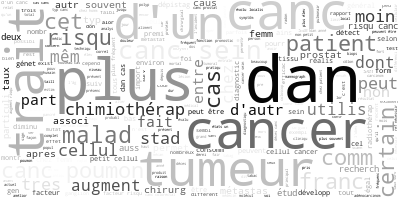

In [27]:
from wordcloud import WordCloud

# Mise en forme des données
texte = [" ".join(i) for i in corpus["contenu_lem"].values]
texte = " ".join(texte)

# Création et visualisation
wordcloud = WordCloud(background_color="white",
                      max_words=5000, contour_width=3)
wordcloud.generate(texte)
wordcloud.to_image()


In [28]:
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases,Phraser
from gensim.models.ldamodel import LdaModel

# Générer les bigrams
phrases = Phrases(list(corpus["contenu_lem"]), 
                    min_count=1, threshold=1)
phraser = Phraser(phrases)
corpus["contenu_lem_bi"] = corpus["contenu_lem"]\
                    .apply(lambda x : phraser[x])

# Création du corpus
dictionnary = Dictionary(corpus["contenu_lem_bi"])
corpus_convert = [dictionnary.doc2bow(line) for 
            line in list(corpus["contenu_lem_bi"])]

# Modélisation
lda_model = LdaModel(corpus=corpus_convert,id2word=dictionnary,
                     num_topics=5,random_state=100,
                     update_every=1,chunksize=100,
                     passes=10, alpha='auto',
                     per_word_topics=True)

# Affichage
categories = lda_model.print_topics()
print(categories[0])

(0, '0.000*"====" + 0.000*"tumeur" + 0.000*"canc" + 0.000*"cancer" + 0.000*"dan" + 0.000*"plus" + 0.000*"trait" + 0.000*"malad" + 0.000*"sein" + 0.000*"cellul"')


In [29]:
page = corpus_convert[1]
attribution = lda_model[page]
print("La classe attribuée à la page est : ",attribution[0])

La classe attribuée à la page est :  [(4, 0.99400216)]


In [30]:
corpus = []
for i in pages[0:8]:
    try:
        p = wp.page(i)
    except wp.DisambiguationError:
        print("La page", repr(i), "est ambigue et sera ignoré.")
        continue
    corpus.append([i,p.links])
print("Nombre de pages : {}".format(len(corpus)))
for i in corpus:
    print("La page {} a {} liens".format(i[0],len(i[1])))

Nombre de pages : 8
La page Cancer a 514 liens
La page Cancer (astrologie) a 80 liens
La page Cancer colorectal a 340 liens
La page Cancer du poumon a 381 liens
La page Cancer du sein a 447 liens
La page Cancer du pancréas a 212 liens
La page Cancer de la prostate a 303 liens
La page Cancer de l'œsophage a 164 liens


In [31]:
import networkx as nx 

# Définition d'un réseau
G = nx.Graph()

# Boucle sur nos données
for p in corpus:
    p_ini = p[0]

    # Ajouter la page ou augmenter son poids
    if not p_ini in G:
        G.add_node(p_ini,size=1)
    else:
        G.nodes[p_ini]["size"]+=1

    # Faire une boucle sur les liens
    for p_ext in p[1]:
        # Ajouter la page du lien ou augmenter son poids
        if not p_ext in G:
            G.add_node(p_ext,size=1)
        else:
            G.nodes[p_ext]["size"]+=1
        
        # Ajouter le lien ou augmenter son poids
        if G.has_edge(p_ini,p_ext):
            G[p_ini][p_ext]["weight"]+=1
        else:
            G.add_edge(p_ini,p_ext,weight=1)    

print("{} nœuds et {} liens".format(G.number_of_nodes(),
                                    G.number_of_edges()))


1493 nœuds et 2425 liens


In [32]:
G_filtre = G.copy()
for n in list(G.nodes(data="size")):
    if n[1]==1:
        G_filtre.remove_node(n[0])
print("{} nœuds et {} liens".format(
            G_filtre.number_of_nodes(), 
            G_filtre.number_of_edges()))


336 nœuds et 1267 liens


La densité du réseau est 0.0022
Le diamètre du réseau est de 5


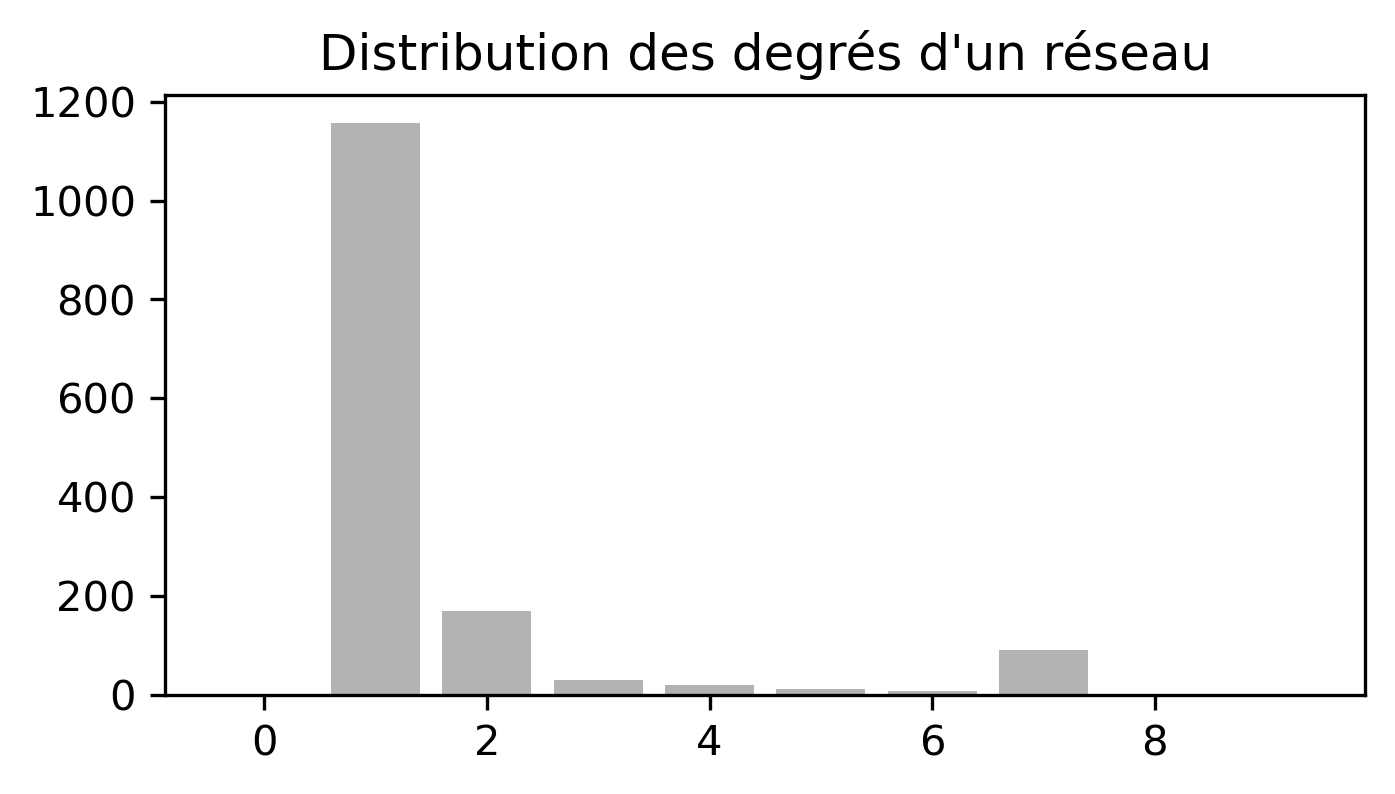

In [33]:
import matplotlib.pyplot as plt 

# Calculs
densite = nx.density(G)
diametre = nx.diameter(G)
hist = nx.degree_histogram(G)

# Affichage
fig,ax = plt.subplots(figsize=(10,5))
ax.bar(range(0,len(hist[0:10])),hist[0:10])
plt.title("Distribution des degrés d'un réseau")
plt.subplots_adjust(left=0.3, right=0.7, top=0.7, bottom=0.3)

print("La densité du réseau est {}".format(round(densite,4)))
print("Le diamètre du réseau est de {}".format(diametre))

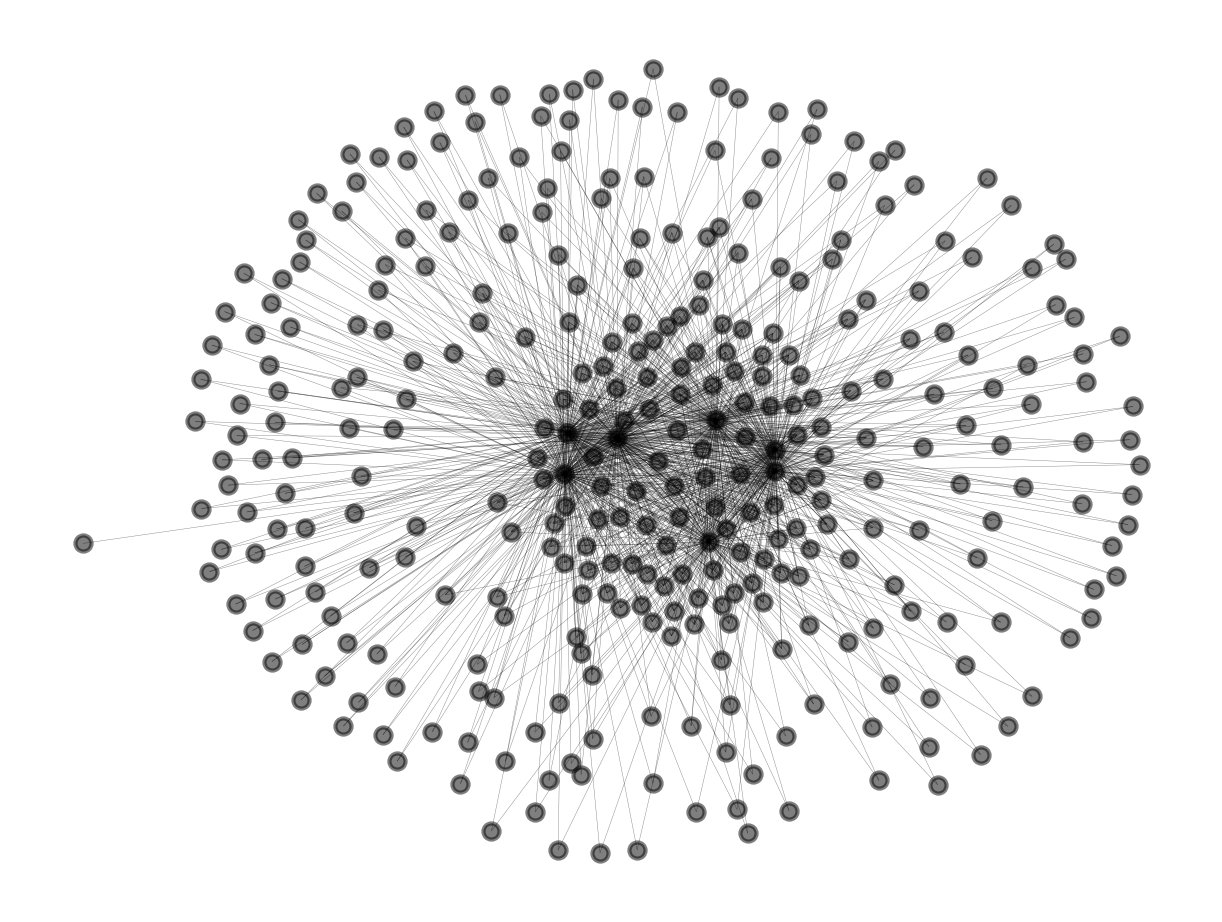

In [34]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(5,5))
nx.draw(G_filtre, pos=nx.spring_layout(G_filtre), 
   node_size=15, width=0.1, alpha=0.5)

In [35]:
nx.write_graphml(G_filtre,"mon_reseau.graphml")

### Cartographie

In [36]:
import geopandas as gpd
fichier = "data/regions-20180101-shp/regions-20180101.shp"
france = gpd.read_file(fichier)
list(france.columns)

['code_insee', 'nom', 'nuts2', 'wikipedia', 'surf_km2', 'geometry']

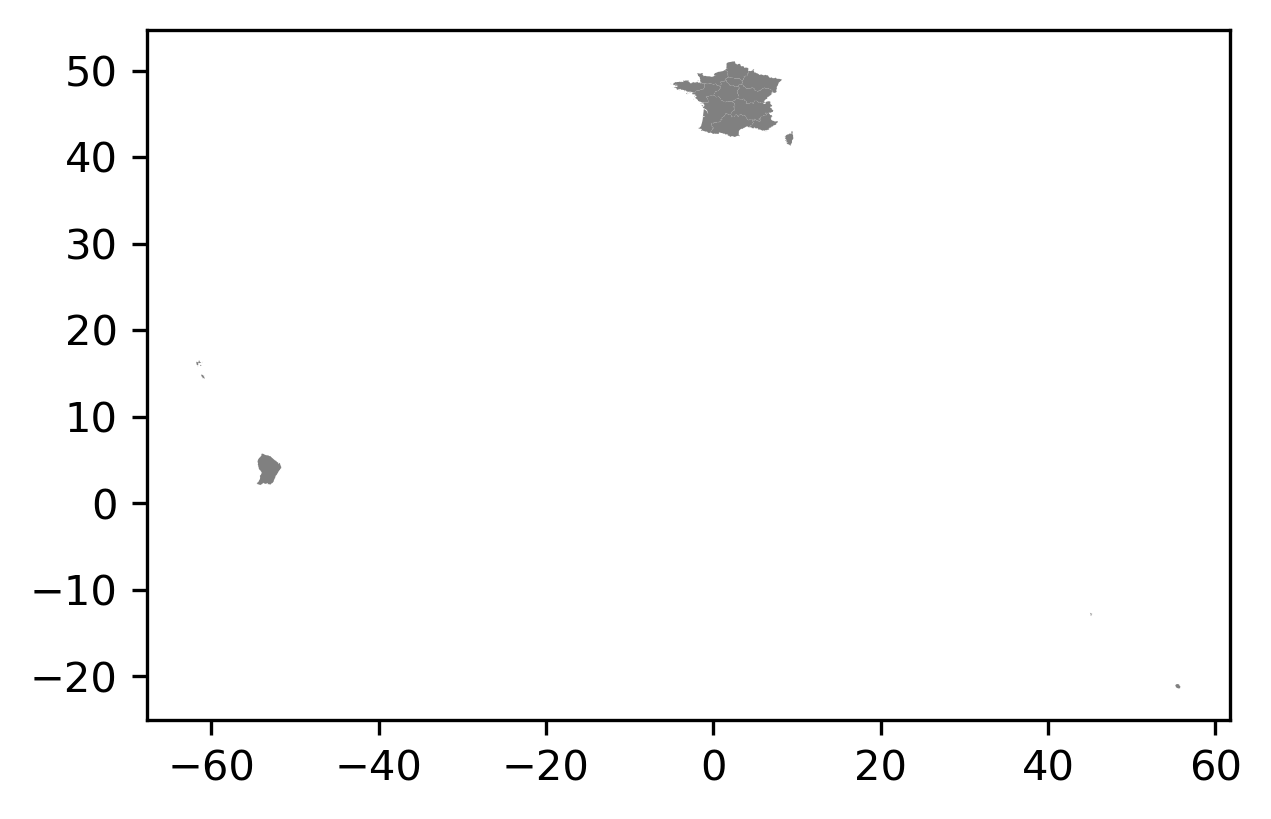

In [37]:
france.plot()
plt.show()

<class 'shapely.geometry.multipolygon.MultiPolygon'>


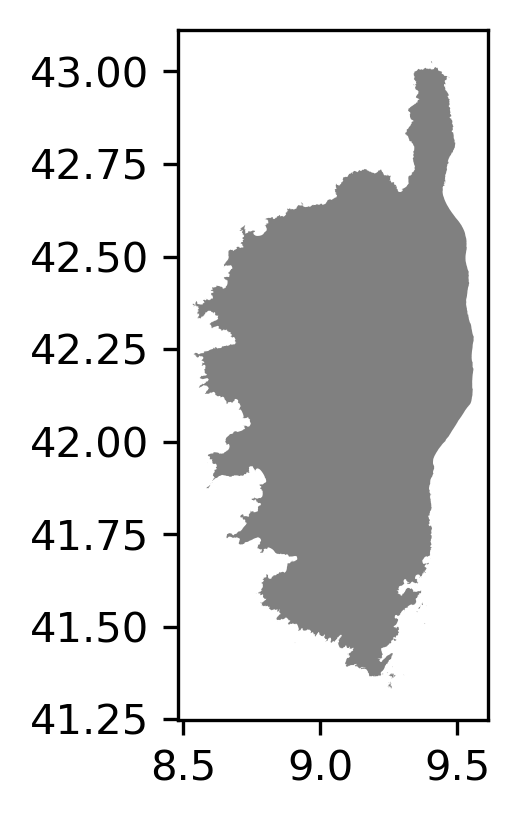

In [38]:
corse = france[france["code_insee"]=="94"]
ax = corse.plot()
print(type(corse.loc[1,"geometry"]))

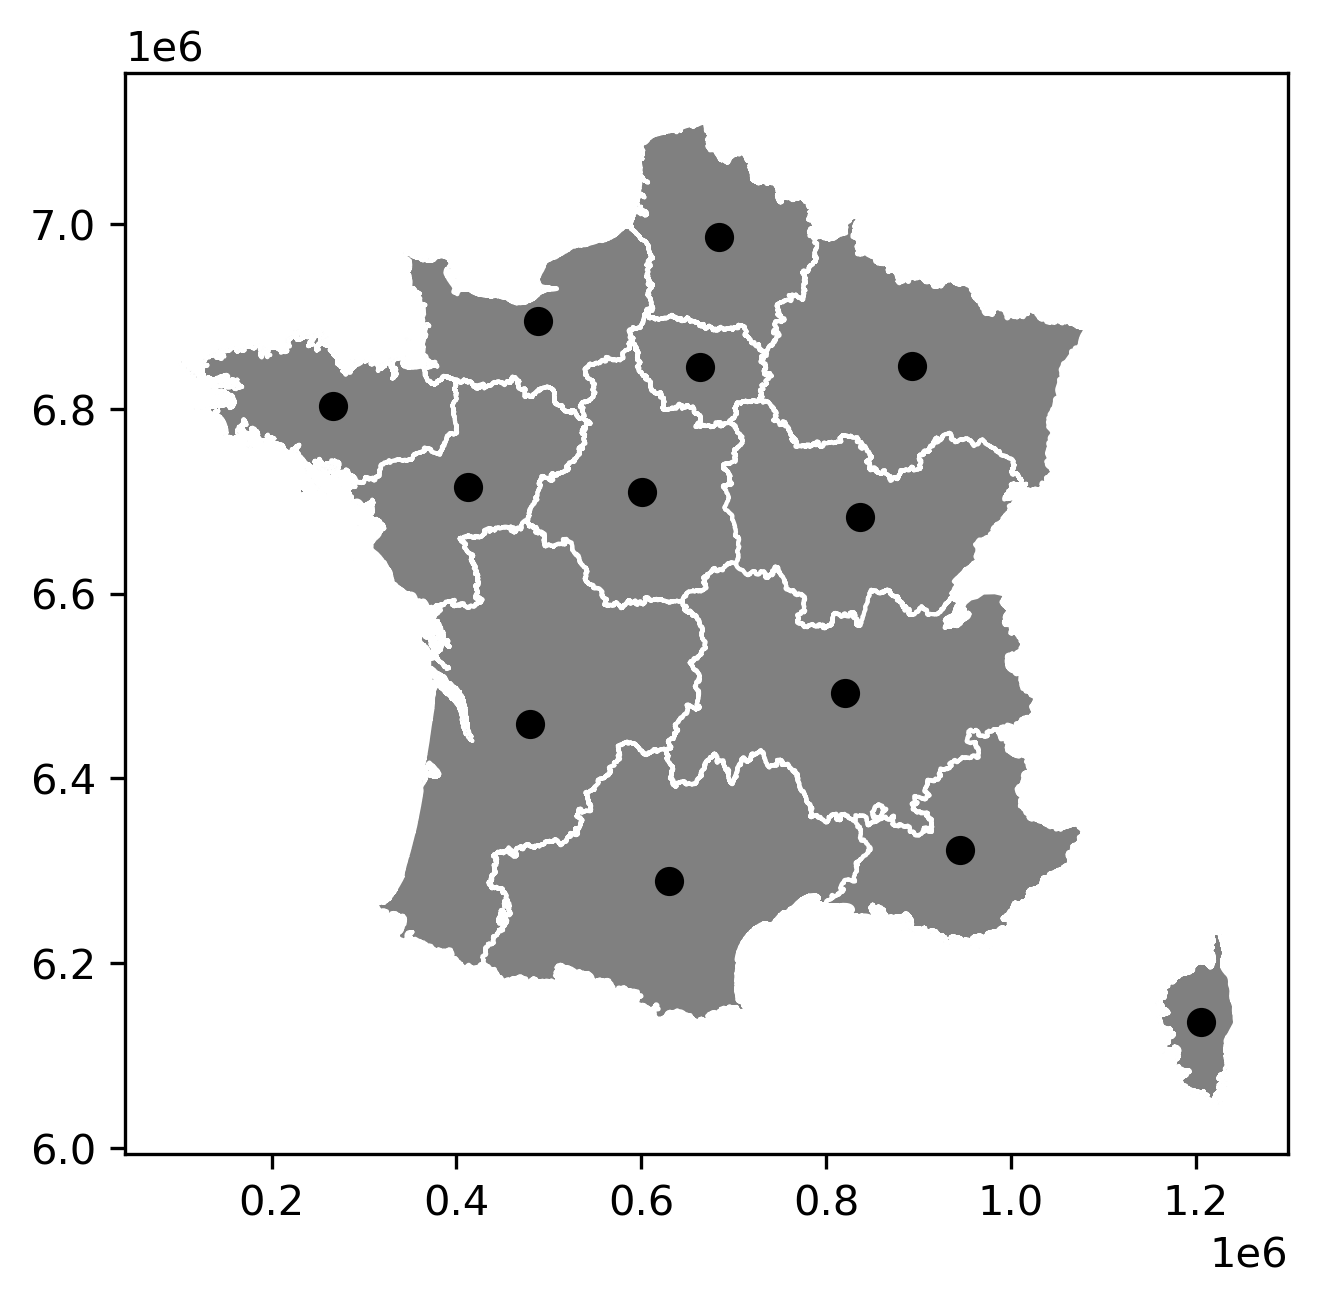

In [39]:
france = france.set_index("code_insee")
france_metropole = france.drop(["01","02","03","04","06"])
france_metropole = france_metropole.to_crs("EPSG:2154")

ax = france_metropole.plot(figsize=(5,10), edgecolor="white")
france_metropole.centroid.plot(ax=ax, color="black")
plt.show()

In [40]:
france_metropole["unite"] = 1
france_metropole = france_metropole.dissolve(by="unite")
distance = france.loc["04"].geometry.distance(
                    france_metropole.centroid.loc[1])
round(distance,2)

6634984.0

In [41]:
tableau = pd.read_csv("./data/data-chap6.csv")
carte = gpd.read_file("./data/communes-20190101.json")
tableau["CODGEO"] = tableau["CODGEO"].apply(str)
d_sup = tableau.set_index("CODGEO")[["P15_POP","prop_f"]]
carte = carte.join(d_sup,on="insee")

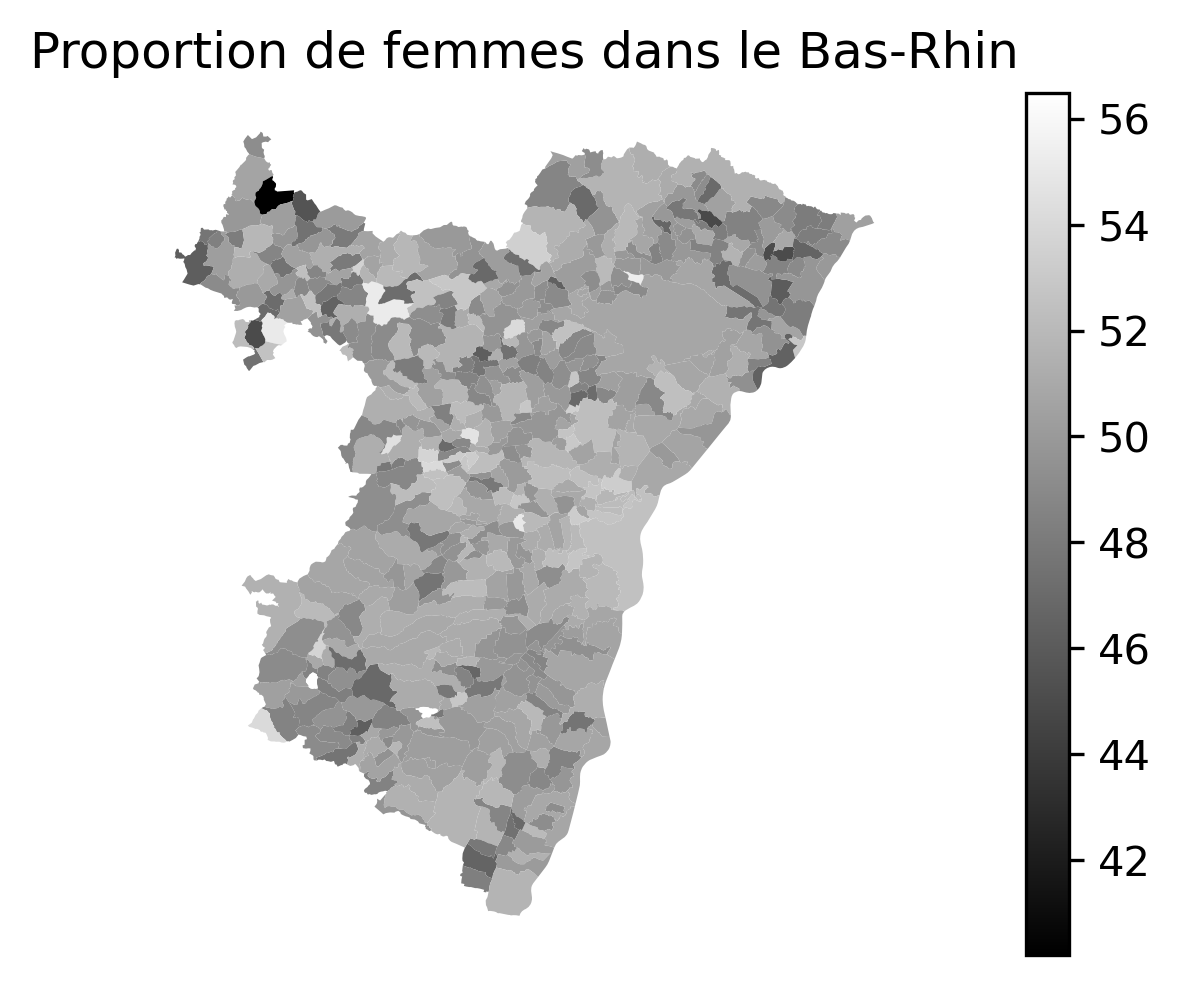

In [42]:
basrhin = carte[carte["insee"]\
    .apply(lambda x : True if x[0:2]=="67" else False)]
basrhin.plot(column='prop_f',legend=True,figsize=(10,5))
plt.axis('off')
plt.title("Proportion de femmes dans le Bas-Rhin")
plt.grid(False)

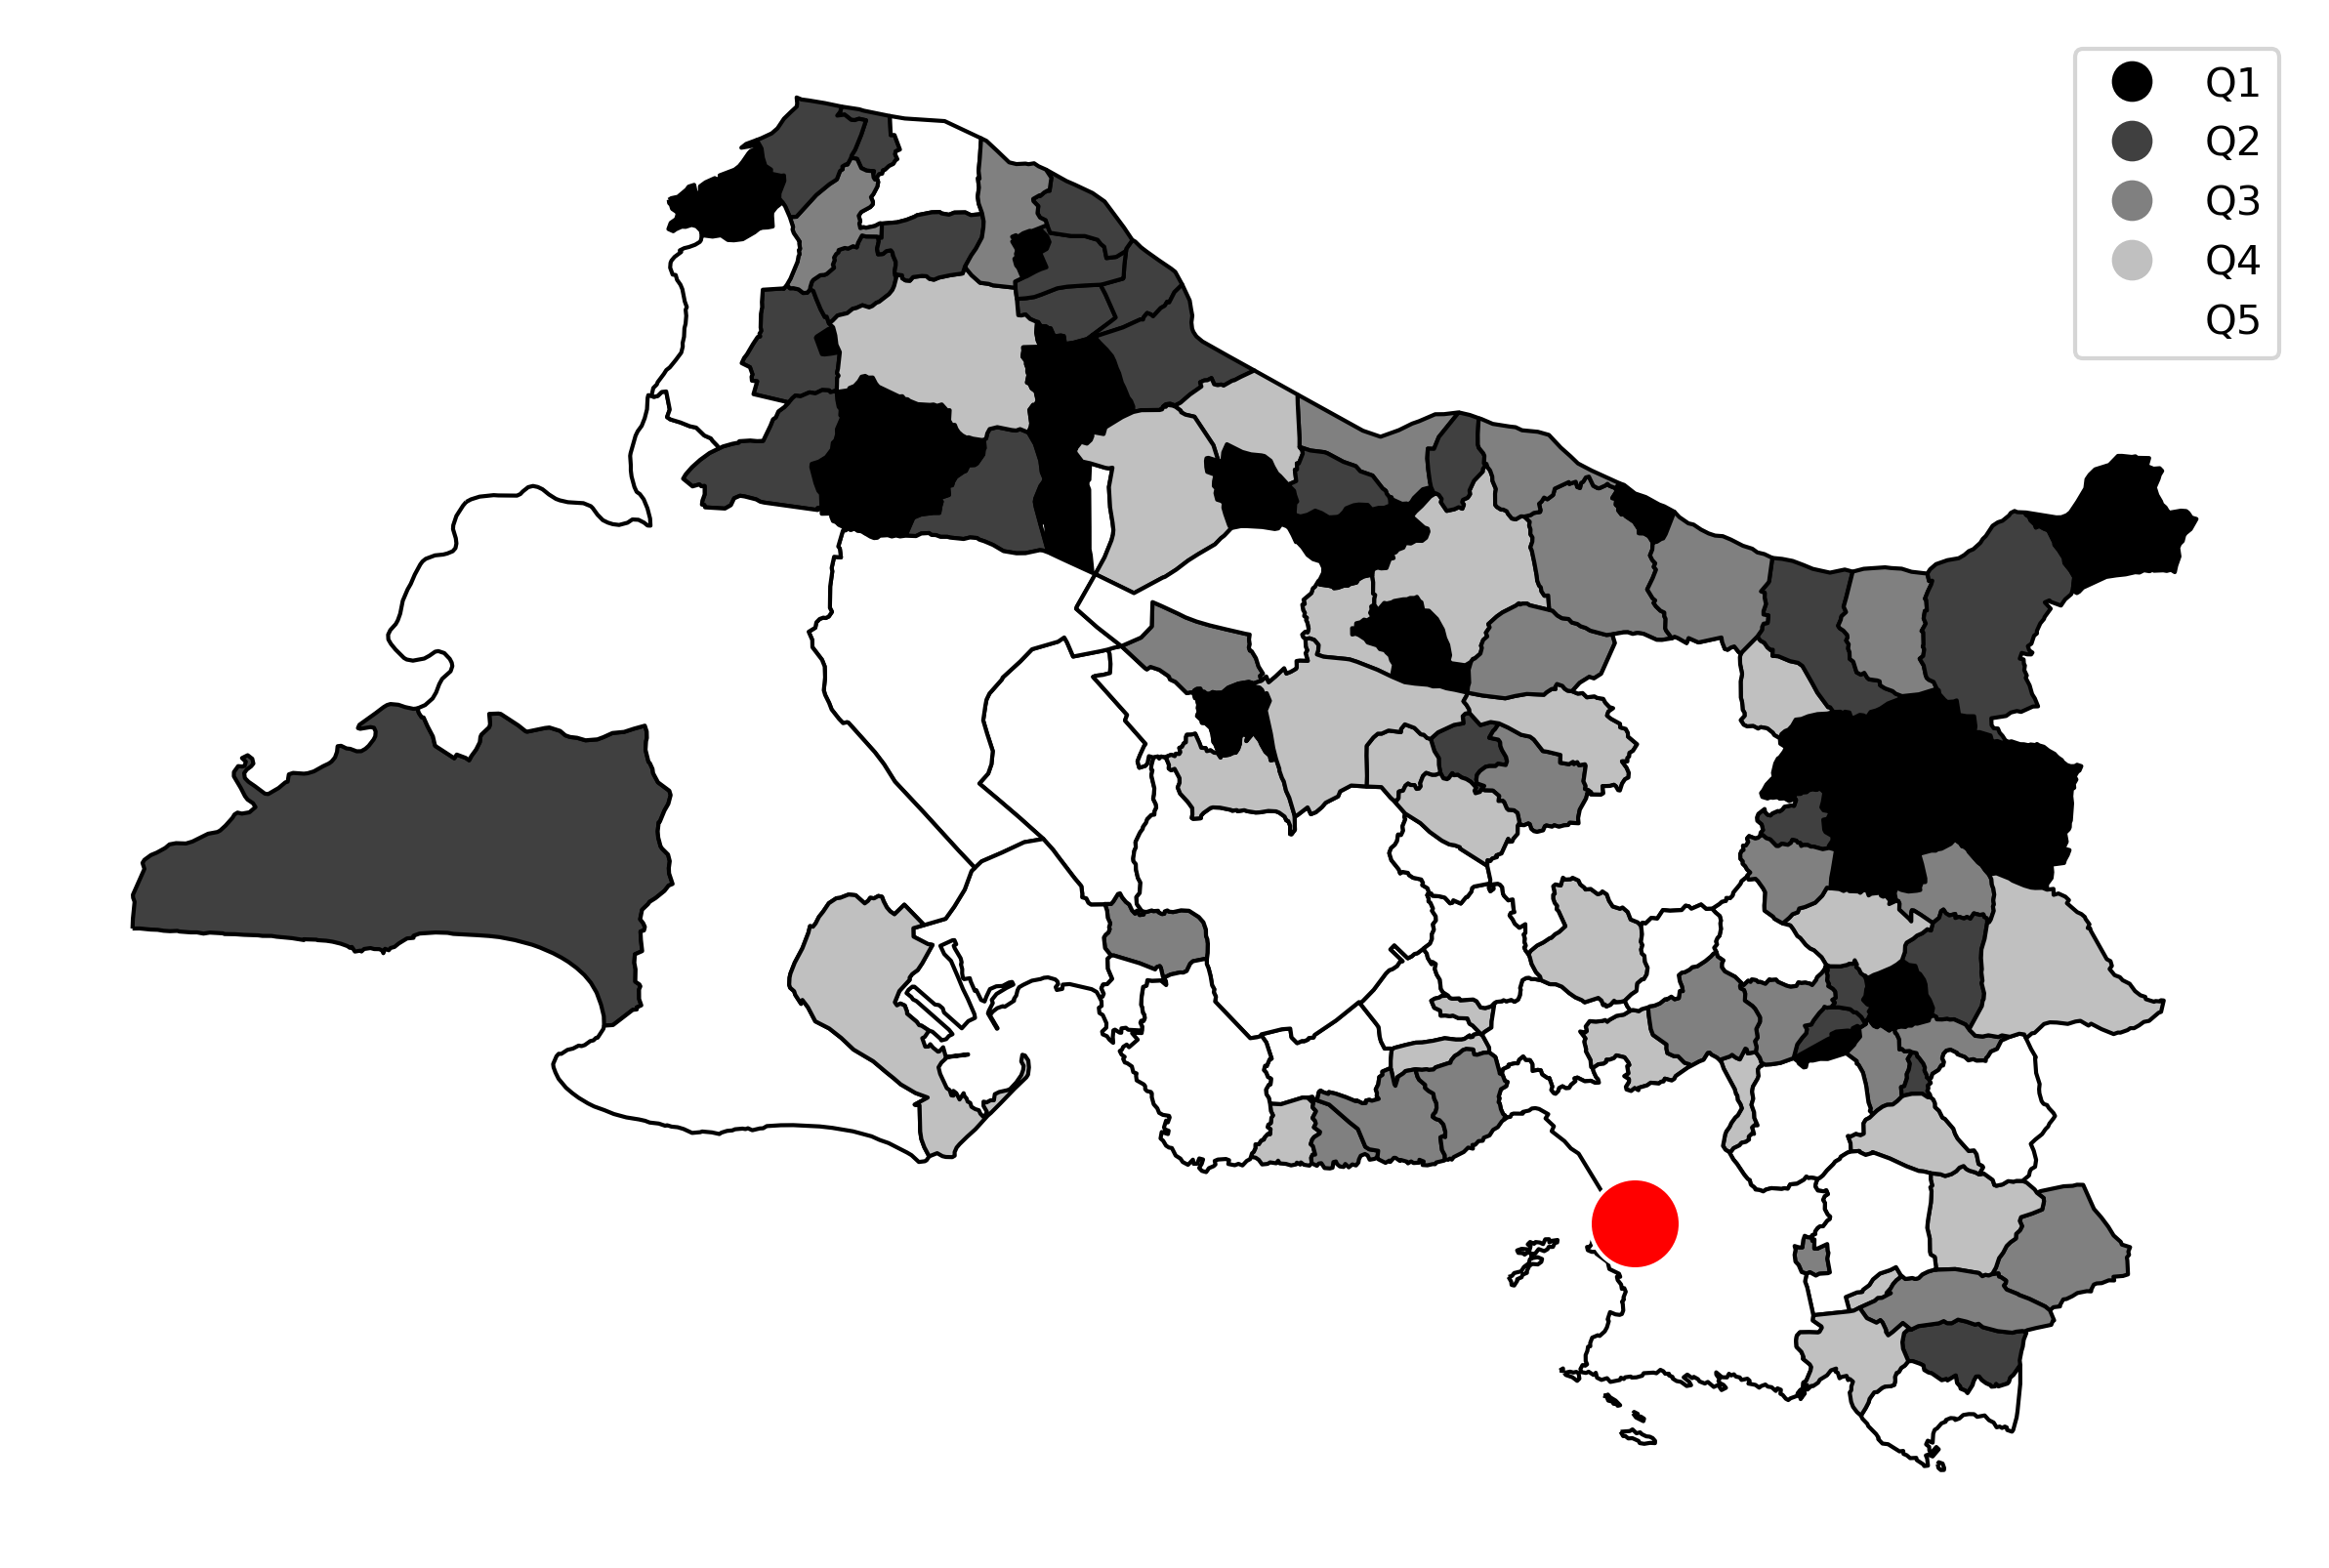

In [43]:
from shapely.geometry import Point

# Mise en forme des données
adresse = geocoder.osm('Cours Julien, Marseille')
point = Point(adresse.json["lng"],adresse.json["lat"])
donnees_points = gpd.GeoDataFrame({'geometry':[point],
                 'info':["Cours Julien"]},crs="epsg:4326")
carte = carte[carte["insee"]\
    .apply(lambda x : True if x[0:2]=="13" else False)]

# Création de la carte
ax = carte.plot(column='P15_POP',legend=True,
                figsize=(10,10),scheme = "quantiles", 
                edgecolor="black")
donnees_points.plot(ax=ax,color="red",edgecolor="white", 
                    markersize=500)

# Mise en forme de la légende
labels = ["Q1","Q2","Q3","Q4","Q5"]
legend_labels = ax.get_legend().get_texts()
for i, legend_label in enumerate(legend_labels):
    legend_label.set_text(labels[i])

# Affichage
plt.grid(False)
plt.axis('off')
plt.show()